**不要轻易运行本程序**

我们将在该数据集上训练两个不同的网络：
- 一个基于OpenCV的MLP
- 一个基于Keras深度神经网络

## 加载MNIST数据集

In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape

11493376/11490434 [==============================] - 6s 1us/step


((60000, 28, 28), (60000,))

标签是0到9之间的整数值（对应数字0～9）：

In [2]:
import numpy as np
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

示例数字：

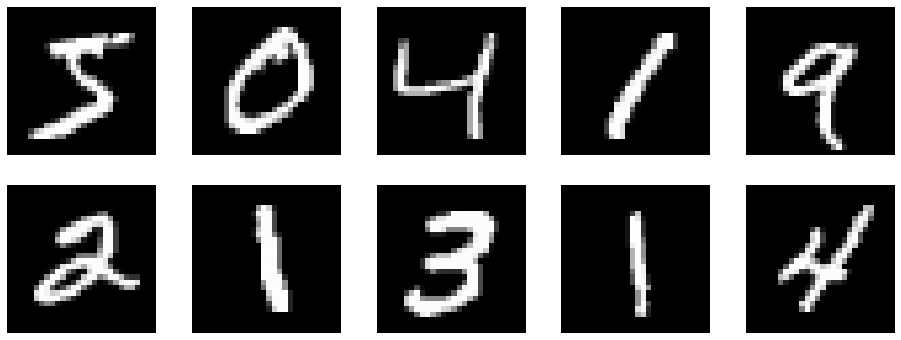

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i, :, :], cmap='gray')
    plt.axis('off')
plt.savefig('mnist-examples.png')

## 预处理MNIST数据集

居中：重要的是，图像中所有的数字都是居中的。例如，看一下图9-15中的数字“1”的所有示例图像，它们几乎都是垂直笔画的。如果不对齐图像，那么笔画会出现在图像中的任何位置，使得神经网络很难发现训练样本的共性。幸运的是，MNIST中的图像都已经居中了。

缩放：同样的道理也适用于缩放数字，以使数字具有相同的大小。这样，笔画、曲线以及环的位置都很重要。否则，神经网络很容易混淆8和0，因为它们都是由一个或者两个闭环组成的。幸运的是，MNIST中的图像都已经被缩放了。

类别特征的表示：重要的是目标标签是独热编码，这样我们可以在输出层有10个神经元对应于0到9的10个不同的类。这一步我们还得自己完成。

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, dtype=np.float32,categories='auto')
y_train_pre = enc.fit_transform(y_train.reshape(-1, 1))
y_test_pre = enc.fit_transform(y_test.reshape(-1, 1))

为了使用OpenCV，我们需要预处理X_train和X_test。当前，X_train和X_test是整数值在0到255之间的三维矩阵<n_samples x 28 x 28>。最好是浮点数的一个二维矩阵<n_samples x n_features>，其中n_features是784，它基本上是将28×28的图像展开成一个784维的向量：

In [5]:
X_train_pre = X_train.astype(np.float32) / 255.0
X_train_pre = X_train_pre.reshape((X_train.shape[0], -1))
X_test_pre = X_test.astype(np.float32) / 255.0
X_test_pre = X_test_pre.reshape((X_test.shape[0], -1))

## 使用OpenCV训练一个多层感知器

In [6]:
import cv2
mlp = cv2.ml.ANN_MLP_create()

# 指定网络中每一层的大小。我们可以随意添加任意个层，但是需要确保第一层的神经元数量和输入特征的数量相同（在我们的例子中是784），最后一层的神经元数与类标签相同（在我们的例子中是10），有两个隐藏层，每个隐藏层有512个节点：
mlp.setLayerSizes(np.array([784, 512, 512, 10]))

# 指定一个激活函数。这里，我们使用之前的S型激活函数：
mlp.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM, 2.5, 1.0)

# 使用之前描述的反向传播算法。我们还需要确保选择一个足够小的学习率。因为我们有10^5指数级的训练样本，最好将学习率设置为最多10^–5：
mlp.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)
mlp.setBackpropWeightScale(0.00001)

# 指定终止条件。这里，我们使用和之前一样的条件：运行训练10次（term_max_iter）或者直到误差不再显著增加（term_eps）：
term_mode = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS
term_max_iter = 10
term_eps = 0.01
mlp.setTermCriteria((term_mode, term_max_iter, term_eps))

# 在训练集（X_train_pre）上训练网络：
mlp.train(X_train_pre, cv2.ml.ROW_SAMPLE, y_train_pre)

# 在训练集上计算准确率得分
_, y_hat_train = mlp.predict(X_train_pre)
from sklearn.metrics import accuracy_score
accuracy_score(y_hat_train.round(), y_train_pre)

0.8539166666666667

In [7]:
# 测试数据的准确率得分：
_, y_hat_test = mlp.predict(X_test_pre)
accuracy_score(y_hat_test.round(), y_test_pre)

0.8488

## 使用Keras训练深度神经网络

### 预处理MNIST数据集

In [8]:
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Keras中的神经网络作用于特征矩阵，与标准OpenCV和scikit-learn估计器稍有不同。而Keras中特征矩阵的行仍然与样本个数（在下面的代码中是X_train.shape\[0]）相对应，我们可以通过增加特征矩阵的维数来保持输入图像的二维属性：

In [9]:
img_rows, img_cols = 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
    
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

像之前那样对训练标签进行独热编码。这会确保目标标签的每个类别都被分配给输出层中的一个神经元。我们可以通过scikit-learn的preprocessing来实现这个任务，但是在本例中，使用Keras自己的实用函数会更容易：

In [10]:
from keras.utils import np_utils
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

### 创建一个卷积神经网络

依赖Sequential模型来定义一个前馈神经网络：

In [11]:
from keras.models import Sequential
model = Sequential()

围绕一个卷积层设计神经网络，核函数是一个3×3像素的二维卷积：

In [12]:
from keras.layers import Conv2D
n_filters = 32
kernel_size = (3, 3)
model.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1]),
                 padding='valid',
                 input_shape=input_shape))

把一个线性修正单元作为激活函数：

In [13]:
from keras.layers import Activation
model.add(Activation('relu'))

在一个深度卷积神经网络中，我们可以有任意多个层。应用于MNIST的这种结构的一个流行版本包括进行两次卷积和修正：

In [14]:
model.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1])))
model.add(Activation('relu'))

对激活函数进行池化操作，并添加一个dropout层：

In [15]:
from keras.layers import MaxPooling2D, Dropout
pool_size = (2, 2)
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

平展模型，并最终通过一个softmax函数将其传递到输出层：

In [16]:
from keras.layers import Flatten, Dense
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

使用交叉熵损失以及adadelta算法：

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

### 拟合模型

In [18]:
model.fit(X_train, Y_train, batch_size=128, epochs=12,
          verbose=1, validation_data=(X_test, Y_test))

Epoch 1/12
469/469 [==============================] - 43s 57ms/step - loss: 2.2913 - accuracy: 0.1307 - val_loss: 2.2501 - val_accuracy: 0.2820
Epoch 2/12
469/469 [==============================] - 27s 58ms/step - loss: 2.2485 - accuracy: 0.1925 - val_loss: 2.1968 - val_accuracy: 0.4017
Epoch 3/12
469/469 [==============================] - 29s 63ms/step - loss: 2.1986 - accuracy: 0.2585 - val_loss: 2.1300 - val_accuracy: 0.5013
Epoch 4/12
469/469 [==============================] - 29s 63ms/step - loss: 2.1353 - accuracy: 0.3281 - val_loss: 2.0441 - val_accuracy: 0.5737
Epoch 5/12
469/469 [==============================] - 30s 64ms/step - loss: 2.0547 - accuracy: 0.3925 - val_loss: 1.9351 - val_accuracy: 0.6376
Epoch 6/12
469/469 [==============================] - 30s 64ms/step - loss: 1.9565 - accuracy: 0.4418 - val_loss: 1.8044 - val_accuracy: 0.6869
Epoch 7/12
469/469 [==============================] - 30s 64ms/step - loss: 1.8453 - accuracy: 0.4901 - val_loss: 1.6554 - val_accuracy:

评估分类器：

In [19]:
model.evaluate(X_test, Y_test, verbose=1)

313/313 [==============================] - 4s 11ms/step - loss: 0.9554 - accuracy: 0.8210


[0.9554135799407959, 0.8209999799728394]